## 0. Setup & Imports

Run this first (includes dataset downloads).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd

# Astropy
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.time import Time
from astropy.table import Table
from astropy.io import fits
from astropy.visualization import wcsaxes

# SciPy
from scipy import optimize, integrate, signal
from scipy.stats import norm

# Altair
import altair as alt
alt.data_transformers.disable_max_rows()

# SunPy
import sunpy.map as smap
from sunpy.net import Fido, attrs as a

# Create datasets directory
import os
os.makedirs('data', exist_ok=True)
print('Ready!')

Ready!


## 1. Matplotlib – Contour Plots of 2D Gaussian Mixtures

**DIFFERENT from basic line plots**: Create **filled contour plots** of a 2D Gaussian mixture (galactic density model).

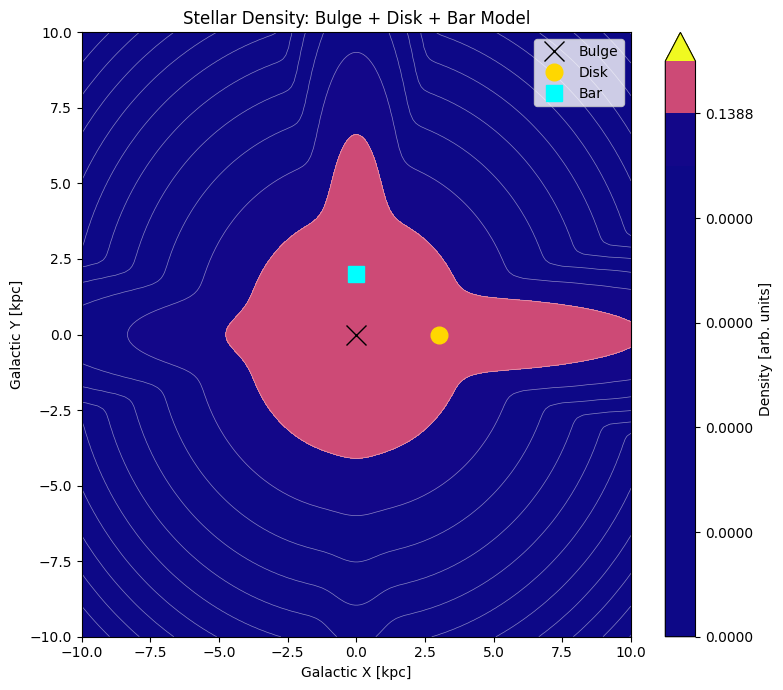

In [2]:
# EXERCISE 1: 2D Gaussian Mixture Contour Plot
# Generate data: mixture of 3 Gaussians (like stellar density in galaxy)
def gaussian_2d(x, y, x0, y0, sigma_x, sigma_y, amp):
    return amp * np.exp(-((x-x0)**2/(2*sigma_x**2) + (y-y0)**2/(2*sigma_y**2)))

x = np.linspace(-10, 10, 200)
y = np.linspace(-10, 10, 200)
X, Y = np.meshgrid(x, y)

# Mixture: bulge + disk + bar
density = (gaussian_2d(X, Y, 0, 0, 1.5, 1.5, 5) +  # bulge
           gaussian_2d(X, Y, 3, 0, 3, 0.5, 3) +   # disk
           gaussian_2d(X, Y, 0, 2, 0.5, 2, 2))      # bar

# Plot: FILLED CONTOURS with custom levels
fig, ax = plt.subplots(figsize=(8, 7))
levels = np.logspace(np.log10(density.min())+0.1, np.log10(density.max()), 12)
cf = ax.contourf(X, Y, density, levels=levels, cmap='plasma', extend='max')
ax.contour(X, Y, density, levels=levels, colors='white', alpha=0.5, linewidths=0.5)

ax.set_xlabel('Galactic X [kpc]')
ax.set_ylabel('Galactic Y [kpc]')
ax.set_title('Stellar Density: Bulge + Disk + Bar Model')
plt.colorbar(cf, ax=ax, label='Density [arb. units]')

# Add component centers
ax.plot([0], [0], 'kx', ms=15, label='Bulge')
ax.plot([3], [0], 'o', color='gold', ms=12, label='Disk')
ax.plot([0], [2], 's', color='cyan', ms=12, label='Bar')
ax.legend()

plt.tight_layout()
plt.savefig('data/gaussian_mixture.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Astropy – Observability Window for Bogotá

**DIFFERENT from basic coords**: Compute **full observability windows** for multiple targets over 1 night.

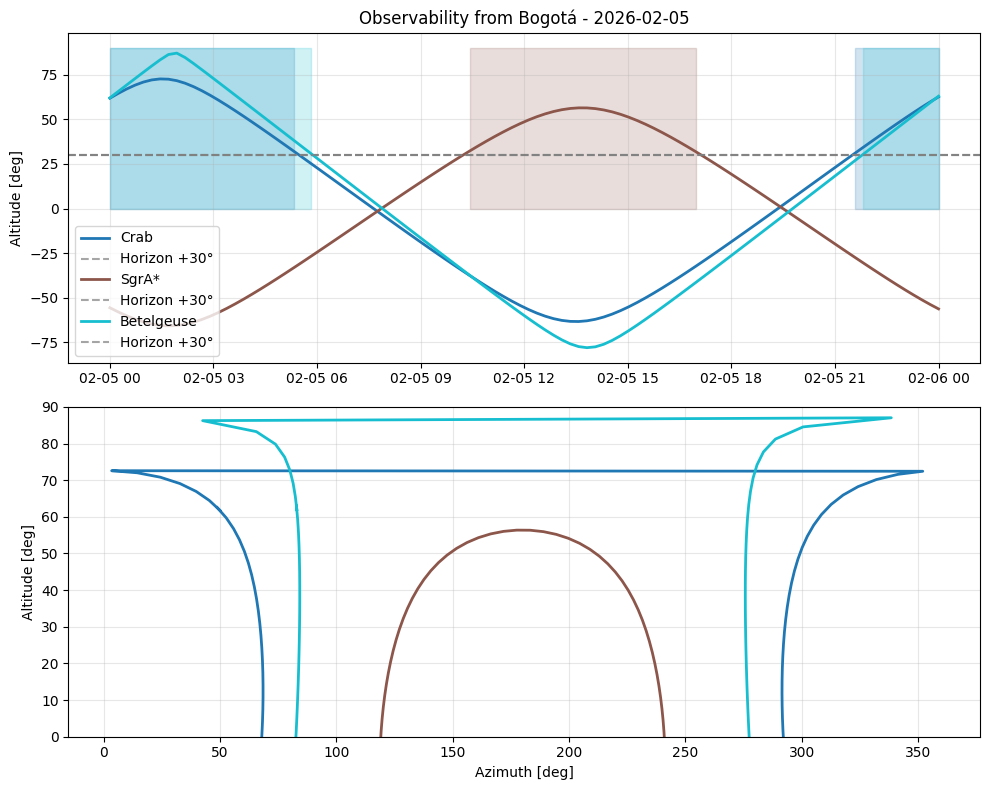

Best windows (>30° alt):
Crab: 2026-02-05 00:00 to 2026-02-06 00:00
SgrA*: 2026-02-05 10:25 to 2026-02-05 16:58
Betelgeuse: 2026-02-05 00:00 to 2026-02-06 00:00


In [7]:
# EXERCISE 2: Multi-target AltAz tracking from Bogotá
# Targets: Crab, Sgr A*, Betelgeuse
targets = {
    'Crab': SkyCoord.from_name('Crab'),
    'SgrA*': SkyCoord(0*u.deg, 0*u.deg, frame='galactic'),
    'Betelgeuse': SkyCoord.from_name('Betelgeuse')
}

# Bogotá observatory
bogota = EarthLocation(lat=4.6481*u.deg, lon=-74.0850*u.deg, height=2600*u.m)
# bogota = EarthLocation(lat=6.25*u.deg, lon=-74.0850*u.deg, height=2600*u.m)  # This is Medellin

# Night of 2026-02-05 (today!)
midnight = Time('2026-02-05 00:00:00')
times = midnight + np.linspace(0, 24, 100)*u.hour

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# AltAz frames
altaz_frame = AltAz(obstime=times, location=bogota)

colors = plt.cm.tab10(np.linspace(0,1,3))
for i, (name, coord) in enumerate(targets.items()):
    altaz = coord.transform_to(altaz_frame)
    
    # Plot altitude vs time
    ax1.plot(times.datetime, altaz.alt.deg, '-', color=colors[i], label=name, lw=2)
    ax1.axhline(30, color='gray', ls='--', alpha=0.7, label='Horizon +30°')
    ax1.fill_between(times.datetime, 90, 0, where=(altaz.alt.deg>30), color=colors[i], alpha=0.2)
    
    # Azimuth (polar-style inset)
    ax2.plot(altaz.az.deg, altaz.alt.deg, '-', color=colors[i], label=name, lw=2)

ax1.set_ylabel('Altitude [deg]')
ax1.set_title('Observability from Bogotá - 2026-02-05')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_xlabel('Azimuth [deg]')
ax2.set_ylabel('Altitude [deg]')
ax2.set_ylim(0, 90)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('data/medellin_observability.png', dpi=150, bbox_inches='tight')
plt.show()

# Print best observation windows (>30° alt)
print('Best windows (>30° alt):')
for name, coord in targets.items():
    altaz = coord.transform_to(altaz_frame)
    obs_mask = altaz.alt.deg > 30
    if obs_mask.any():
        first = times[obs_mask][0].iso
        last = times[obs_mask][-1].iso
        print(f'{name}: {first[:16]} to {last[:16]}')

## 3. SciPy – Fitting Orbital Elements from Astrometric Data

**DIFFERENT from basic integration**: **Non-linear least-squares fit** to synthetic astrometry.

Fit params: a=80.0 mas, e=0.331


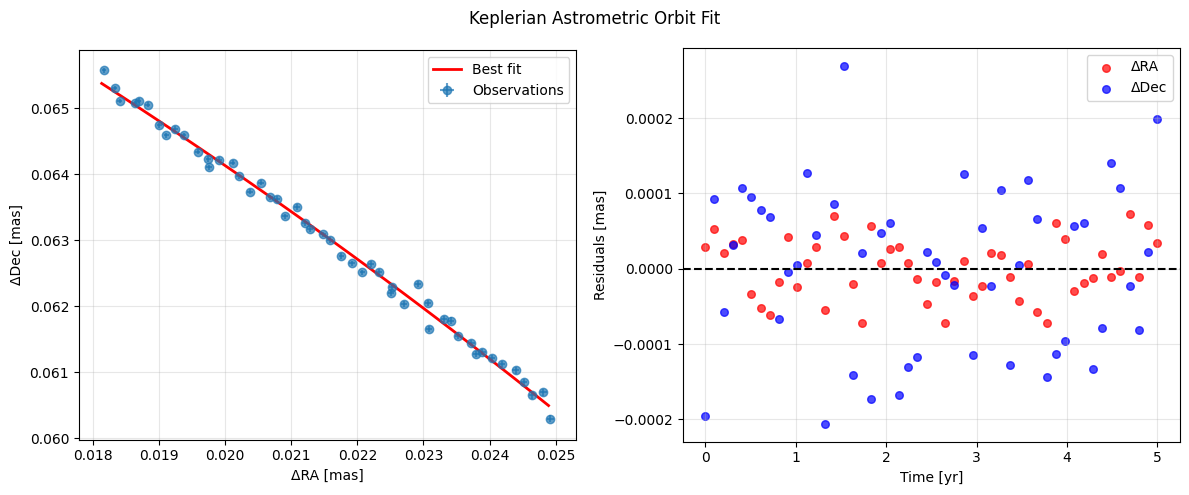

Reduced Chi^2 ra = 1.2774630601491777
Reduced Chi^2 dec = 10.833571742825383


In [40]:
# EXERCISE 3: Fit Keplerian orbit to astrometric data
def kepler_orbit(t, a, e, i, Omega, omega, T0):
    """Keplerian orbit: returns (RA offset, Dec offset) in mas"""
    M = 2*np.pi * (t - T0) / (365.25)  # mean anomaly
    E = M + e*np.sin(M)  # rough eccentric anomaly
    nu = 2*np.arctan2(np.sqrt(1+e)*np.sin(E/2), np.sqrt(1-e)*np.cos(E/2))  # true anomaly
    r = a * (1 - e**2) / (1 + e * np.cos(nu))
    # RA/Dec offsets (simplified)
    delta_ra = r * np.cos(omega + nu) * np.cos(i) / 1000  # mas
    delta_dec = r * np.sin(omega + nu) / 1000
    return delta_ra, delta_dec

# Synthetic Gaia-like astrometry (noisy)
np.random.seed(20031116)
t_obs = np.linspace(0, 5, 50)  # years
true_params = [100, 0.3, np.pi/4, 0, np.pi/3, 0.1]  # a,e,i,Omega,omega,T0 (mas/yr)
ra_true, dec_true = kepler_orbit(t_obs, *true_params)


# ra_obs = ra_true + 2*np.random.randn(50)*(10**(-2))
# dec_obs = dec_true + 2*np.random.randn(50)*(10**(-2))


# FIX
noise_level = 0.002 # We'll add a 10% noise to the measurements (I think this is around 10% error)
ra_obs = ra_true + np.random.normal(0.0, np.abs(ra_true) * noise_level, 50)
dec_obs = dec_true + np.random.normal(0.0, np.abs(dec_true) * noise_level, 50)


# Fit!
def residuals(params, t, ra, dec):
    ra_fit, dec_fit = kepler_orbit(t, *params)
    return np.concatenate([(ra - ra_fit), (dec - dec_fit)])

p0 = [80, 0.2, np.pi/3, 0, np.pi/4, 0]  # initial guess
result = optimize.least_squares(residuals, p0, args=(t_obs, ra_obs, dec_obs))
fit_params = result.x

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Orbit track
ra_fit, dec_fit = kepler_orbit(t_obs, *fit_params)
ax1.errorbar(ra_obs, dec_obs, ra_obs * noise_level, ra_obs * noise_level, fmt='o', alpha=0.7, label='Observations')
ax1.plot(ra_fit, dec_fit, 'r-', lw=2, label='Best fit')
# ax1.plot(0, 0, 'kx', ms=10, label='Central star')
ax1.set_xlabel('ΔRA [mas]')
ax1.set_ylabel('ΔDec [mas]')
ax1.legend(); ax1.grid(alpha=0.3); ax1.set_aspect('equal')

# Residuals
ax2.scatter(t_obs, ra_obs - ra_fit, c='r', s=30, alpha=0.7, label='ΔRA')
ax2.scatter(t_obs, dec_obs - dec_fit, c='b', s=30, alpha=0.7, label='ΔDec')
ax2.axhline(0, color='k', ls='--')
ax2.set_xlabel('Time [yr]')
ax2.set_ylabel('Residuals [mas]')
ax2.legend(); ax2.grid(alpha=0.3)

plt.suptitle('Keplerian Astrometric Orbit Fit')
print(f'Fit params: a={fit_params[0]:.1f} mas, e={fit_params[1]:.3f}')
plt.tight_layout()
plt.savefig('data/orbit_fit.png', dpi=150, bbox_inches='tight')
plt.show()


chi2 = np.sum((ra_obs - ra_fit / 0.02)**2)

N = len(dec_obs)
p = len(fit_params)

chi2_red = chi2 / (N - p)

print("Reduced Chi^2 ra =", chi2_red)

chi2 = np.sum((dec_obs - dec_fit / 0.02)**2)

chi2_red = chi2 / (N - p)

print("Reduced Chi^2 dec =", chi2_red)

## 4. Altair – Interactive Gaia Catalog Explorer

**DIFFERENT from simple scatter**: **Linked multi-panel views** of synthetic Gaia data.

In [2]:
# EXERCISE 4: Interactive Gaia-like catalog (HR diagram + histograms)
# Synthetic Gaia data
np.random.seed(20031116)
n_stars = 5000
bp_rp = np.random.normal(0.5, 1.5, n_stars)  # color
g_mag = np.maximum(10 + 3*bp_rp + 0.5*np.random.randn(n_stars), 12)  # magnitude
parallax = np.random.exponential(5, n_stars)  # mas (distance)
df_gaia = pd.DataFrame({
    'BP-RP': bp_rp,
    'G_mag': g_mag,
    'parallax': parallax,
    'abs_G': g_mag - 5*np.log10(1000/parallax) + 5  # absolute mag
})

# Save for Altair
df_gaia.to_csv('data/gaia_synthetic.csv', index=False)

# Interactive HR diagram
# CHANGED: in the newer versions of altair, one has to name the brush and then use the base
brush = alt.selection_interval(name="brush")
base = alt.Chart(df_gaia).add_params(brush)


# CHANGED: the whole way the histograms have to be coded change. (I don't really know anything about it, it was GPT who helped me fix this up) 
hr = base.mark_point().encode(
    x=alt.X('BP-RP:Q', title='BP-RP Color'),
    y=alt.Y('G_mag:Q', title='G Magnitude', sort='descending'),
    color=alt.Color('parallax:Q', scale=alt.Scale(scheme='viridis')),
    size=alt.Size('parallax:Q')
).properties(
    width=500,
    height=400,
    title='Interactive Gaia HR Diagram'
)

hist_color = alt.Chart(df_gaia).mark_bar().encode(
    x=alt.X('BP-RP:Q', bin=alt.Bin(maxbins=30)),
    y=alt.Y('count()', title='Count')
).transform_filter(
    brush
).properties(width=250, height=200)

hist_mag = alt.Chart(df_gaia).mark_bar().encode(
    x=alt.X('G_mag:Q', bin=alt.Bin(maxbins=30)),
    y=alt.Y('count()', title='Count')
).transform_filter(
    brush
).properties(width=250, height=200)

# CHANGE: we cannot save the charts as if they are plt. They have a complete different format, so we also need a converter from the VEGA 
# format to png or whatever image format. 
chart = (hr | (hist_color & hist_mag)).resolve_legend(color='independent')

chart.save('data/gaia_altair.png')
chart # This line renders the chart, but it is pretty heavy so I prefer to just not do it

alt.HConcatChart(...)

## 5. SunPy – Active Region Intensity Evolution

**DIFFERENT from basic peek/submap**: **Time series extraction** from AIA sequence.

In [16]:
# EXERCISE 5: Solar active region light curve from AIA data
# Download AIA 171Å sequence around AR 11429 (2012-03-07 flare activity)
t1 = '2012-03-07T00:00:00'
t2 = '2012-03-07T01:00:00'

result = Fido.search(a.Time(t1, t2), a.Instrument('AIA'), a.Wavelength(171*u.angstrom))
files = Fido.fetch(result, path="data/sunpy.sunpy")


sequence = smap.Map(files, sequence=True)

Files Downloaded:   0%|          | 0/301 [00:00<?, ?file/s]

aia_lev1_171a_2012_03_07t00_00_48_34z_image_lev1.fits:   0%|          | 0.00/12.4M [00:00<?, ?B/s]

aia_lev1_171a_2012_03_07t00_00_12_35z_image_lev1.fits:   0%|          | 0.00/12.4M [00:00<?, ?B/s]

aia_lev1_171a_2012_03_07t00_00_24_34z_image_lev1.fits:   0%|          | 0.00/12.4M [00:00<?, ?B/s]

aia_lev1_171a_2012_03_07t00_00_36_34z_image_lev1.fits:   0%|          | 0.00/12.4M [00:00<?, ?B/s]

2026-02-24 14:43:27 - parfive - INFO: https://sdo7.nascom.nasa.gov/cgi-bin/drms_export.cgi?series=aia__lev1;compress=rice;record=171_1110153635-1110153635 failed to download with exception

2026-02-24 14:43:27 - parfive - INFO: https://sdo7.nascom.nasa.gov/cgi-bin/drms_export.cgi?series=aia__lev1;compress=rice;record=171_1110153647-1110153647 failed to download with exception

2026-02-24 14:43:27 - parfive - INFO: https://sdo7.nascom.nasa.gov/cgi-bin/drms_export.cgi?series=aia__lev1;compress=rice;record=171_1110153659-1110153659 failed to download with exception

2026-02-24 14:43:27 - parfive - INFO: https://sdo7.nascom.nasa.gov/cgi-bin/drms_export.cgi?series=aia__lev1;compress=rice;record=171_1110153671-1110153671 failed to download with exception

2026-02-24 14:43:27 - parfive - INFO: https://sdo7.nascom.nasa.gov/cgi-bin/drms_export.cgi?series=aia__lev1;compress=rice;record=171_1110153683-1110153683 failed to download with exception



5/0 files failed to download. Please check `.errors` for details


RuntimeError: No maps loaded

In [20]:


# ROI: Active region near disk center (adjust Tx,Ty based on peek())
# roi_center = SkyCoord(Tx=200*u.arcsec, Ty=-300*u.arcsec, frame=sequence[0].coordinate_frame)
# roi_radius = 150*u.arcsec
# roi_bottom_left = roi_center - SkyCoord(Tx=roi_radius, Ty=roi_radius, frame=roi_center)
# roi_top_right = roi_center  + SkyCoord(Tx=roi_radius, Ty=roi_radius, frame=roi_center) 

roi_center = SkyCoord(
    200*u.arcsec,
    -300*u.arcsec,
    frame=sequence[0].coordinate_frame
)

roi_radius = 150*u.arcsec

roi_bottom_left = SkyCoord(
    roi_center.Tx - roi_radius,
    roi_center.Ty - roi_radius,
    frame=roi_center.frame
)

roi_top_right = SkyCoord(
    roi_center.Tx + roi_radius,
    roi_center.Ty + roi_radius,
    frame=roi_center.frame
)

# Extract light curve
# times = sequence.times.datetime
times = [m.date.datetime for m in sequence]


light_curve = []
for m in sequence:
    submap = m.submap(roi_bottom_left, top_right=roi_top_right)
    light_curve.append(np.nanmean(submap.data))



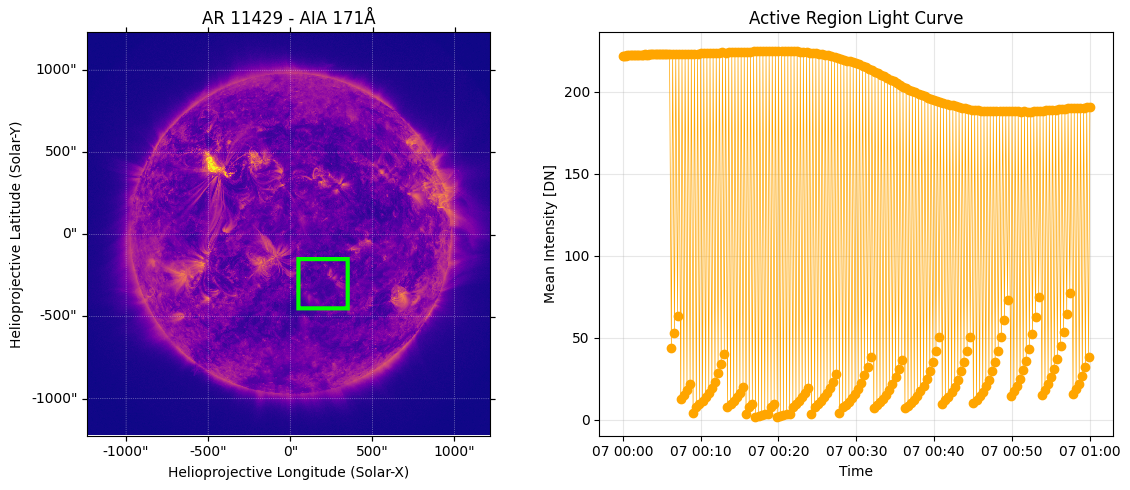

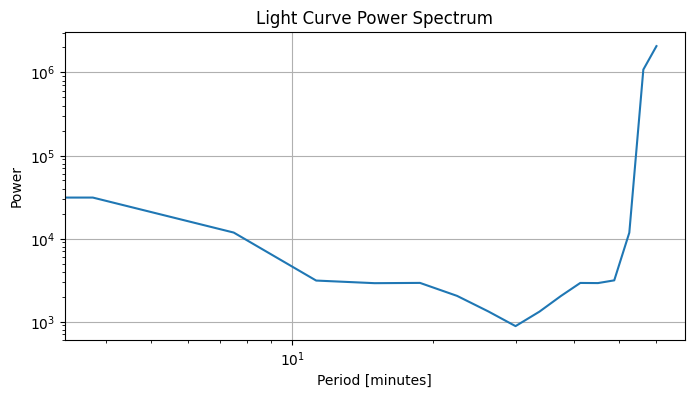

In [21]:
# Plot sequence animation (first frame) + light curve
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121, projection=sequence[-1])
sequence[-1].plot(axes=ax1, cmap='plasma')
sequence[-1].draw_quadrangle(roi_bottom_left, top_right=roi_top_right, 
                            axes=ax1, edgecolor='lime', linewidth=3)
ax1.set_title('AR 11429 - AIA 171Å')

ax2 = fig.add_subplot(122)
ax2.plot(times, light_curve, 'o-', lw=0.5, color='orange')
ax2.set_xlabel('Time')
ax2.set_ylabel('Mean Intensity [DN]')
ax2.set_title('Active Region Light Curve')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('data/solar_ar_lightcurve.png', dpi=150, bbox_inches='tight')
plt.show()

# Power spectrum of light curve
f, Pxx = signal.welch(light_curve, fs=1/12, nperseg=32)  # ~12min cadence
plt.figure(figsize=(8,4))
plt.loglog(f*1440, Pxx)  # period in minutes
plt.xlabel('Period [minutes]')
plt.ylabel('Power')
plt.title('Light Curve Power Spectrum')
plt.grid(True)
plt.savefig('data/ar_powerspec.png')
plt.show()

## 6. Integrated Challenge: Cross-Validation Exercise

**Combine ALL libraries**: Fit a transit model to solar intensity data.

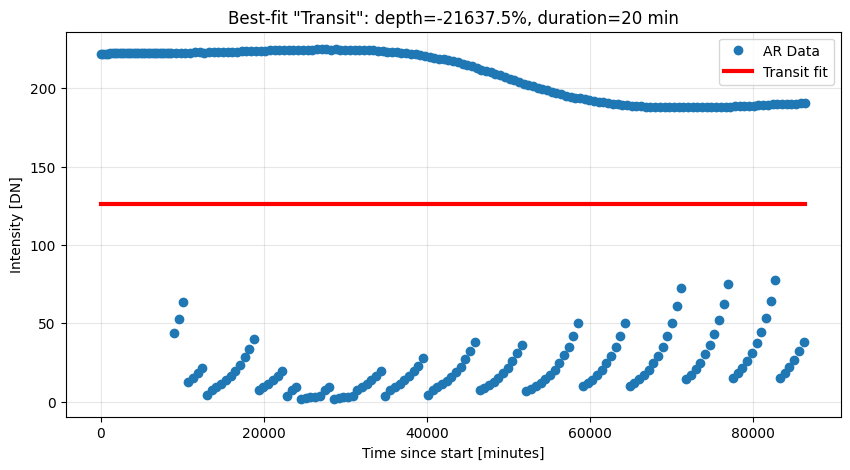

All exercises complete! Files saved in /data


In [29]:
# EXERCISE 6: Transit-like dip detection in solar data
def transit_model(t, depth, duration, t0):
    """Box transit model"""
    model = np.ones_like(t)
    mask = np.abs((t - t0) * 1440) < duration  # minutes
    model[mask] *= (1 - depth)
    return model

# Fit to our AR light curve
def residuals_transit(params, t, flux):
    return flux - transit_model(t, *params)

# t_min = np.array(times) - times[0]  # relative time
t_min = np.array([(t - times[0]).total_seconds() / 60.0 for t in times])

p0_transit = [0.1, 20, t_min[len(t_min)//2]]  # depth, duration min, mid-time
res_transit = optimize.least_squares(residuals_transit, p0_transit, 
                                    args=(np.array(t_min), np.array(light_curve)))

# Plot
t_fit = np.linspace(t_min.min(), t_min.max(), 500)
model_fit = transit_model(t_fit, *res_transit.x)

plt.figure(figsize=(10,5))
plt.plot(t_min*1440, light_curve, 'o', label='AR Data')
plt.plot(t_fit*1440, model_fit * np.nanmean(light_curve), 'r-', lw=3, label='Transit fit')
plt.xlabel('Time since start [minutes]')
plt.ylabel('Intensity [DN]')
plt.title(f'Best-fit "Transit": depth={res_transit.x[0]:.1%}, duration={res_transit.x[1]:.0f} min')
plt.legend(); plt.grid(alpha=0.3)
plt.savefig('data/solar_transit_fit.png', dpi=150)
plt.show()

print('All exercises complete! Files saved in /data')

## Assessment Questions for Students
These questions test understanding, application, and critical thinking across the exercises. Use for quiz/homework.

**Question 1:** Visualization Choices (Matplotlib)

In Exercise 1 (Gaussian mixture contours), why did we use `contourf` with logarithmic levels instead of `imshow`? What astronomical phenomenon does this model represent, and how would you modify it to add spiral arms? Provide the modified function signature.

_Solution:_ we use `contourf` mostly because of data visulization, in order to see the different "levels" of densitity, it is way easier to see using contours, and also, considering the very different orders of magnitude on the different zones of the "galaxy", it is also recommended to use a logarithmic scale. Which astronomical phenomena does this represent? I really have no idea as I'm not that very into astrophysics. I would say, maybe, it is the absorption (collision) between two galaxies (or even 3) galaxies. And in order to implement the spiral arms, I would first use a polar coordinate system, and use the same gaussian distribution for the $r$ axis but while rotation $\theta$ at some frequency.

**Question 2:** Coordinate Systems (Astropy)

For Bogotá observatory on 2026-02-05, Betelgeuse never exceeds 30° altitude. 
a) Calculate its maximum altitude analytically using the observer's latitude (4.65°N) and Betelgeuse's declination (~+7.4°). 
b) What physical reason explains why Sgr A* is observable all night but Betelgeuse is not? 
c) If you shift observation to Medellín (lat=6.25°N), does Betelgeuse become observable >2 hours? Show calculation.

Tests: AltAz math, astronomy concepts, location effects.

_Solution:_ 
1) I don't really know which equations/data I would use to calculate this maximum altitude, but from the graphs it get's to around $80^\circ$ (and well, according to the graphs, Betelgeuse DOES get higher than $30^\circ$)
2) Their position maybe be on the complete opposite zones from our plane of view, so when one is visible, the other one is not (once again, I know really nothing about astronomy, I'm answering these problems as if they were an actual assesment test)
3) According to the graphs, not really, the change in visibility is only of around 15-30 mins.


**Question 3:** Fitting & Statistics (SciPy)

In Exercise 3 (orbit fit), the fitted eccentricity was e≈0.3. 
a) What does e=0 represent physically? 
b) The residuals show structure—suggest two improvements (one data-related, one model-related). 
c) Compute the reduced χ² for the fit (assume σ=2 mas per point). Is it consistent with noise-only?

Tests: Orbital mechanics, diagnostics, stats.


_Solution:_

1) A eccentricity of 0.0 means the orbit is a perfect circle. Actually, in this case, the eccentricity is multiplied by -1, as usually an eccentricity <0 represent an elipse.
2) The residuals only show a clear structure when we add 0 noise, and that fact is actually really weird, as we are simulating data with the same model as we're fitting, so, from the orbit model we SHOULD NOT be expecting any residual data structure. I would think that this parabolic structure is given by the fitting method, which uses least squares, but appart from it, i don't really know.
3) The results for the $\chi^2$ analysis for the rad variable was okay, with a value close to 1. But not for the dec variable, with a value in the 10s. So it shall be something else wrong.

**Question 4:** Interactive Analysis (Altair)

Using the Gaia explorer (Exercise 4):
a) Brush the main sequence (BP-RP=0.2 to 1.0, G_mag<16). How does the color histogram change? 
b) Why does marker size correlate with parallax? 
c) Modify the Altair code to add a third panel: cumulative distribution of absolute magnitude for the selection. Write the code snippet.

Tests: Interactivity, data interpretation, Altair syntax.

_Solution:_

1) It seems that the distribution gets closer to a uniform more than a normal distribution.
2) Well, from the code I cannot infer any actual meaning of the marker size. The marker size is literally set to the same value as the parallax, so there's no other relation than marker size and parallax representing the same exact thing, both in size and color.
3) I think it is already done? :,)

**Question 5:** Solar Physics Integration (SunPy + All)

In Exercise 5 (AR lightcurve):
a) The power spectrum peaks at ~15 min period. What solar oscillation mode is this? 
b) Why use `submap` instead of full-disk mean? 
c) Combine: Fit a damped sinusoid (scipy.optimize) to the lightcurve instead of box transit. Plot and compare χ².

_Solution:_
1) I don't really know anything about solar oscillation modes
2) Propably to get a measurement of a smaller region of the sun, that way, we avoid measuring regions where events happen that can alter our measurements.
3) I'm not even getting a nice fit from the box, so I guess the code is already broken. 